In [1]:
import os
import copy
from mmcv.transforms import Compose
from mmengine.config import Config
from mmpretrain.registry import TRANSFORMS, DATASETS
import matplotlib.pyplot as plt
import cv2
import numpy as np

from mmbreast import *

/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv`` rather than ``mmcv-lite`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDefo

In [12]:
img_prefix="../datasets/mmbreast/"
config = "configs/from_imagenet/efficiennet-b3-fold_0_4gencam.py"
cfg = Config.fromfile(config)
data_list =  DATASETS.build(cfg.test_dataloader.dataset).load_data_list()
img_skip = 4
skipped = 0

for item in data_list:
    if item['cancer'] == 1:
        skipped += 1
    if skipped == img_skip:
        break
print(item)

{'patient_id': 'C_0003_1', 'image_id': 'C_0003_1|RIGHT|MLO', 'view': 'MLO', 'laterality': 'R', 'density': 'B', 'age': 46.0, 'ddsm_ori_status': 'Cancer', 'cancer': 1, 'split': 2.0, 'dataset': 'miniddsm'}


In [13]:

filename = f"{item['patient_id']}@{item['image_id']}.png"
filename = os.path.join(
    img_prefix, f"{item['dataset']}/cleaned_images/", filename
)
src_img = cv2.imread(filename)
assert src_img is not None

In [18]:
filename = os.path.join(
    img_prefix, "bmcd/cleaned_images/normal_25@normal_25MLO_prior.png"
)
src_img = cv2.imread(filename)
assert src_img is not None

(4072, 1297, 3)


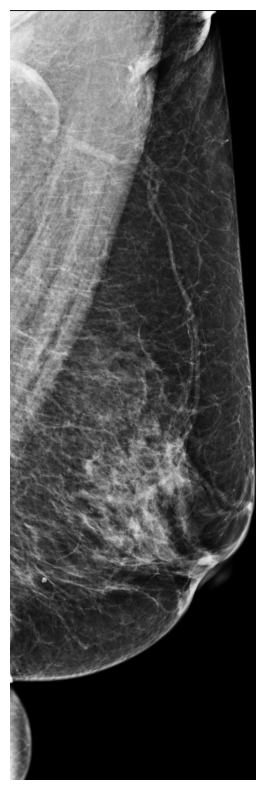

In [19]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(src_img)
print(src_img.shape)

True

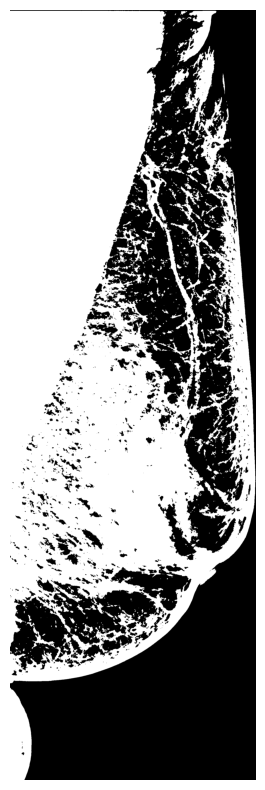

In [22]:
# Convert to grayscale
gray = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
# Apply GaussianBlur to smooth the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply a binary threshold to create a binary image
_, binary_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(binary_mask, cmap='gray')
cv2.imwrite("thresh.png", binary_mask)

(3546, 1290, 3)


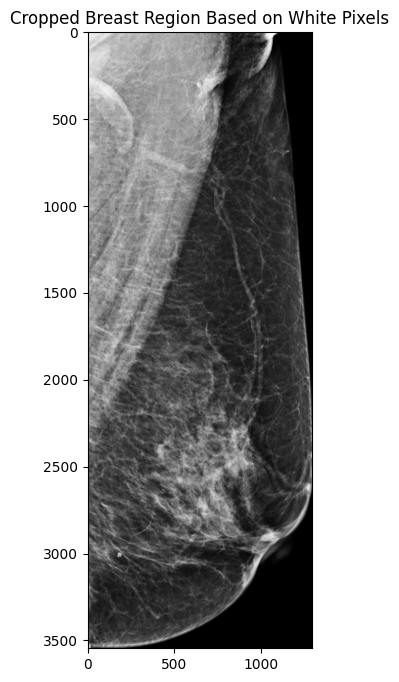

In [23]:
def find_largest_true_sequence_indices(bool_list):
    max_sequence = 0  # To store the maximum length of True values
    current_sequence = 0  # To count the current sequence of True values
    start_index = -1  # To store the start index of the current sequence
    max_start = -1  # To store the start index of the largest sequence
    max_end = -1  # To store the end index of the largest sequence

    for i, value in enumerate(bool_list):
        if value:
            if current_sequence == 0:
                start_index = i  # Mark the start of the sequence
            current_sequence += 1
        else:
            if current_sequence > max_sequence:
                max_sequence = current_sequence
                max_start = start_index
                max_end = i - 1  # End index is the last True index
            current_sequence = 0  # Reset the current sequence

    # In case the list ends with a True sequence
    if current_sequence > max_sequence:
        max_start = start_index
        max_end = len(bool_list) - 1  # End index is the last True index

    return (max_start, max_end)


# Function to find crop boundaries based on white pixel percentage
def find_breast_region_edges(binary_mask, white_pixel_threshold=0.3):
    binary_mask[binary_mask==255] = 1
    sum_rows = np.sum(binary_mask, axis=1)
    threshhold_row = np.mean(sum_rows) * white_pixel_threshold
    sum_cols = np.sum(binary_mask, axis=0)
    threshhold_col = np.mean(sum_cols) * white_pixel_threshold
    sum_rows[sum_rows < threshhold_row] = False
    sum_rows[sum_rows > threshhold_row] = True
    sum_cols[sum_cols < threshhold_col] = False
    sum_cols[sum_cols > threshhold_col] = True
    # Initialize edges
    top, bottom = find_largest_true_sequence_indices(sum_rows)
    left, right = find_largest_true_sequence_indices(sum_cols)
    return top, bottom, left, right

# Get the crop boundaries based on the binary mask
top, bottom, left, right = find_breast_region_edges(binary_mask, 0.1)

# Crop the original image based on the calculated edges
cropped_image = src_img[top:bottom+1, left:right+1]
print(cropped_image.shape)

# Show the cropped breast region
plt.figure(figsize=(8, 8))
plt.title("Cropped Breast Region Based on White Pixels")
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))  # If the original image is in color
plt.show()
